# HoloViz and scverse

## Motivation

### Scanpy’s plotting API is overloaded

- which parameters are statistical, which presentational?

```python
def dotplot(  # noqa: PLR0913
    adata: AnnData,
    var_names: _VarNames | Mapping[str, _VarNames],
    groupby: str | Sequence[str],
    *,
    use_raw: bool | None = None,
    log: bool = False,
    num_categories: int = 7,
    categories_order: Sequence[str] | None = None,
    expression_cutoff: float = 0.0,
    mean_only_expressed: bool = False,
    standard_scale: Literal["var", "group"] | None = None,
    title: str | None = None,
    colorbar_title: str | None = DotPlot.DEFAULT_COLOR_LEGEND_TITLE,
    size_title: str | None = DotPlot.DEFAULT_SIZE_LEGEND_TITLE,
    figsize: tuple[float, float] | None = None,
    dendrogram: bool | str = False,
    gene_symbols: str | None = None,
    var_group_positions: Sequence[tuple[int, int]] | None = None,
    var_group_labels: Sequence[str] | None = None,
    var_group_rotation: float | None = None,
    layer: str | None = None,
    swap_axes: bool | None = False,
    dot_color_df: pd.DataFrame | None = None,
    show: bool | None = None,
    save: str | bool | None = None,
    ax: _AxesSubplot | None = None,
    return_fig: bool | None = False,
    vmin: float | None = None,
    vmax: float | None = None,
    vcenter: float | None = None,
    norm: Normalize | None = None,
    # Style parameters
    cmap: Colormap | str | None = DotPlot.DEFAULT_COLORMAP,
    group_colors: Mapping[str, ColorLike] | None = None,
    dot_max: float | None = DotPlot.DEFAULT_DOT_MAX,
    dot_min: float | None = DotPlot.DEFAULT_DOT_MIN,
    smallest_dot: float = DotPlot.DEFAULT_SMALLEST_DOT,
    **kwds,
) -> DotPlot | dict | None: ...
```

### Matplotlib is slow …

> For instance, making a multi-panel UMAP plot with 2M cells that takes **1min15s** with <samp>sc.pl.umap</samp> takes **7s** with datashader.
> 
> – *Gregor Sturm in [scverse/scanpy#2656](https://github.com/scverse/scanpy/issues/2656)*

### … and fiddly

- 2/3 new issues in the last week are about plotting.
- fixing them rarely feels like progress.

> When plotting in given `ax`, for continuous variable, `sc.pl.scatter` seems to mislocate the colorbar […]
> 
> 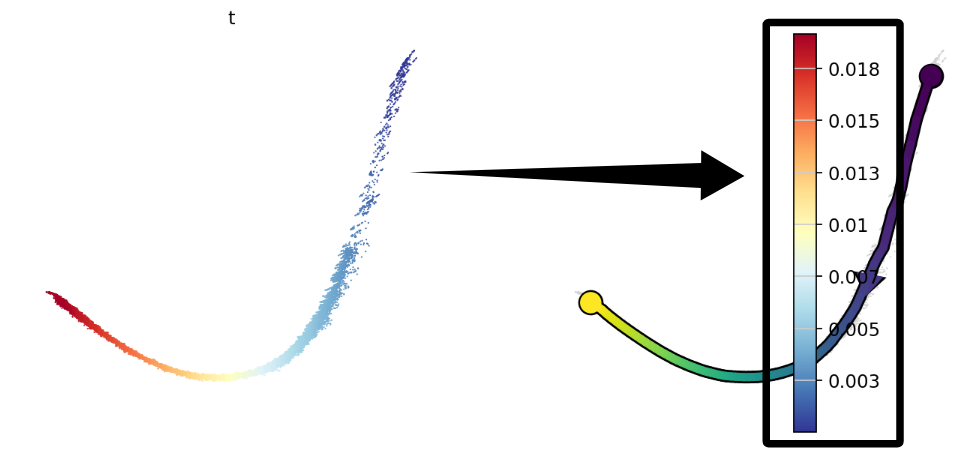
>
> *– [@Fantasque68](https://github.com/Fantasque68) in [scverse/scanpy#3963](https://github.com/scverse/scanpy/issues/3963)*, 4 days ago

## Solution

In [ ]:
import holoviews as hv

from hv_anndata.interface import ACCESSOR as A  # soon: from anndata.acc import A
from hv_anndata.interface import register

register()
hv.extension("bokeh")

### Simple plots need “no” API!

In [ ]:
import scanpy as sc

adata = sc.datasets.pbmc3k_processed()
scatter = hv.Scatter(
    adata, A.obsm["X_umap"][0], [A.obsm["X_umap"][1], A.obs["louvain"]]
).opts(color=A.obs["louvain"], responsive=True, height=500)
scatter

### and customization is easy

In [ ]:
(
    scatter
    .opts(tools=["hover"], cmap="tab10")
    .opts(legend_position="left", responsive=False, frame_width=400)
    .hist()
)

### especially with helpers like this

In [ ]:
hv.help(hv.Scatter)

## Easy to build on

In [ ]:
import hv_anndata

hv_anndata.ManifoldMap(
    adata=adata, datashade=False, reduction="X_umap", show_labels=True
)

### Another example

In [ ]:
import panel as pn

pn.extension("jsoneditor")

marker_genes = {
    "CD4 T cells": ["IL7R"],
    "CD14+ Monocytes": ["CD14", "LYZ"],
    "B cells": ["MS4A1"],
    "CD8 T cells": ["CD8A"],
    "NK cells": ["GNLY", "NKG7"],
    "FCGR3A+ Monocytes": ["FCGR3A", "MS4A7"],
    "Dendritic Cells": ["FCER1A", "CST3"],
    "Megakaryocytes": ["PPBP"],
}
hv_anndata.Dotmap(adata=adata, marker_genes=marker_genes, groupby="louvain")

### As powerful as we need

In [ ]:
markers = ["CST3", "FCER1A", "FCGR3A", "GNLY", "MS4A1", "NKG7", "PPBP"]

heatmap = hv.HeatMap(
    adata[:, markers], [A.obs.index, A.var.index], [A[:, :], A.obs["n_counts"]]
).opts(xticks=0, width=600)

hv.operation.dendrogram(heatmap, adjoint_dims=[A.obs.index], main_dim=A[:, :])

## Perfection doesn’t exist

- the heatmap above took far too long for no good reason
- you noticed the mish-mash of `frame_{widgth,height}=…`, `width/height=…`, and `responsive=…`
- hvplot API might be nice?

In [ ]:
sc.pl.dogplot(adata)

## more

- [hv-anndata.rtfd.io](https://hv-anndata.rtfd.io)
- [holoviews.org](https://holoviews.org/) (Especially “User Guides”!)